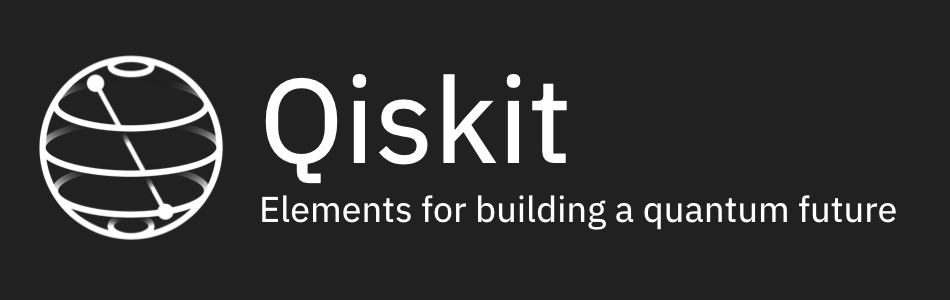

# Measurement Error Mitigation

* **Last Updated:** May 2, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2

## Introduction

The measurement calibration is used to mitigate measurement errors. 
The main idea is to prepare all $2^n$ basis input states and compute the probability of measuring counts in the other basis states. 
From these calibrations, it is possible to correct the average results of another experiment of interest. This notebook gives examples for how to use the ``ignis.mitigation.measurement`` module.

In [9]:
# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## 3 Qubit Example of the Calibration Matrices

Assume that we would like to generate a calibration matrix for the 3 qubits Q2, Q3 and Q4 in a 5-qubit Quantum Register [Q0,Q1,Q2,Q3,Q4]. 

Since we have 3 qubits, there are $2^3=8$ possible quantum states.

## Generating Measurement Calibration Circuits

First, we generate a list of measurement calibration circuits for the full Hilbert space. 
Each circuit creates a basis state. 
If there are $n=3$ qubits, then we get $2^3=8$ calibration circuits.

The following function **complete_meas_cal** returns a list **meas_calibs** of `QuantumCircuit` objects containing the calibration circuits, 
and a list **state_labels** of the calibration state labels.

The input to this function can be given in one of the following three forms:

- **qubit_list:** A list of qubits to perform the measurement correction on, or:
- **qr (QuantumRegister):** A quantum register, or:
- **cr (ClassicalRegister):** A classical register.

In addition, one can provide a string **circlabel**, which is added at the beginning of the circuit names for unique identification.

For example, in our case, the input is a 5-qubit `QuantumRegister` containing the qubits Q2,Q3,Q4:

In [2]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
qubit_list = [2,3,4]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

Print the $2^3=8$ state labels (for the 3 qubits Q2,Q3,Q4):

In [3]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

## Computing the Calibration Matrix

If we do not apply any noise, then the calibration matrix is expected to be the $8 \times 8$ identity matrix.

In [10]:
provider = IBMQ.get_provider(hub='ibm-q-internal',group='dev-qiskit')
backend = provider.get_backend('ibmq_johannesburg')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"
backend_defaults = backend.defaults()

dt = backend_config.dt
print(f"Sampling time: {dt} ns")    # The configuration returns dt in seconds

Sampling time: 3.5555555555555554e-09 ns


/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:356: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [12]:
# Execute the calibration circuits without noise
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [13]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.926 0.031 0.036 0.    0.066 0.003 0.003 0.   ]
 [0.01  0.892 0.    0.054 0.001 0.074 0.    0.003]
 [0.008 0.    0.884 0.036 0.    0.    0.073 0.002]
 [0.    0.015 0.008 0.854 0.    0.002 0.    0.061]
 [0.054 0.001 0.007 0.    0.921 0.039 0.046 0.001]
 [0.    0.06  0.    0.002 0.006 0.876 0.    0.038]
 [0.002 0.    0.064 0.001 0.006 0.    0.872 0.026]
 [0.    0.001 0.001 0.053 0.    0.006 0.006 0.869]]


Assume that we apply some noise model from Qiskit Aer to the 5 qubits, 
then the calibration matrix will have most of its mass on the main diagonal, with some additional 'noise'.

Alternatively, we can execute the calibration circuits using an IBMQ provider.

In [14]:
# Generate a noise model for the 5 qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])

In [15]:
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

In [16]:
# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.739 0.21  0.201 0.05  0.21  0.051 0.048 0.018]
 [0.069 0.631 0.02  0.152 0.021 0.193 0.005 0.035]
 [0.081 0.017 0.61  0.165 0.024 0.006 0.18  0.039]
 [0.009 0.07  0.077 0.533 0.004 0.02  0.022 0.138]
 [0.081 0.016 0.021 0.01  0.606 0.169 0.158 0.035]
 [0.008 0.051 0.002 0.018 0.061 0.486 0.021 0.15 ]
 [0.012 0.    0.064 0.021 0.069 0.023 0.508 0.123]
 [0.001 0.005 0.005 0.051 0.005 0.052 0.058 0.462]]


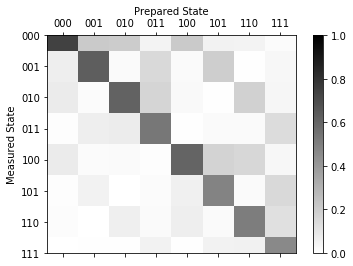

In [17]:
# Plot the calibration matrix
meas_fitter.plot_calibration()

## Analyzing the Results

We would like to compute the total measurement fidelity, and the measurement fidelity for a specific qubit, for example, Q0.

Since the on-diagonal elements of the calibration matrix are the probabilities of measuring state 'x' given preparation of state 'x', 
then the trace of this matrix is the average assignment fidelity.


In [18]:
# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['000','001','010','011'],['100','101','110','111']]))

Average Measurement Fidelity: 0.571875
Average Measurement Fidelity of Q0: 0.827500


## Applying the Calibration

We now perform another experiment and correct the measured results. 

## Correct Measurement Noise on a 3Q GHZ State

As an example, we start with the 3-qubit GHZ state on the qubits Q2,Q3,Q4:

$$ \mid GHZ \rangle = \frac{\mid{000} \rangle + \mid{111} \rangle}{\sqrt{2}}$$

In [19]:
# Make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

We now execute the calibration circuits (with the noise model above):

In [20]:
job = qiskit.execute([ghz], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

We now compute the results without any error mitigation and with the mitigation, namely after applying the calibration matrix to the results.

There are two fitting methods for applying the calibration (if no method is defined, then 'least_squares' is used). 
- **'pseudo_inverse'**, which is a direct inversion of the calibration matrix, 
- **'least_squares'**, which constrains to have physical probabilities.

The raw data to be corrected can be given in a number of forms:

- Form1: A counts dictionary from results.get_counts,
- Form2: A list of counts of length=len(state_labels),
- Form3: A list of counts of length=M*len(state_labels) where M is an integer (e.g. for use with the tomography data),
- Form4: A qiskit Result (e.g. results as above).

In [21]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

We can now plot the results with and without error mitigation:

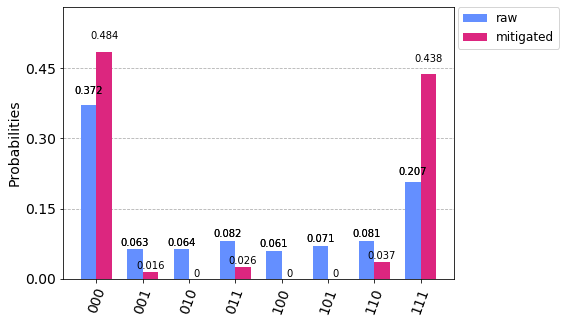

In [22]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

### Applying to a reduced subset of qubits

Consider now that we want to correct a 2Q Bell state, but we have the 3Q calibration matrix. We can reduce the matrix and build a new mitigation object.

In [23]:
# Make a 2Q Bell state between Q2 and Q4
cr = ClassicalRegister(2)
bell = QuantumCircuit(qr, cr)
bell.h(qr[2])
bell.cx(qr[2], qr[4])
bell.measure(qr[2],cr[0])
bell.measure(qr[4],cr[1])

In [24]:
job = qiskit.execute([bell], backend=backend, shots=5000, noise_model=noise_model)
results = job.result()

In [25]:
#build a fitter from the subset
meas_fitter_sub = meas_fitter.subset_fitter(qubit_sublist=[2,4])

In [26]:
#The calibration matrix is now in the space Q2/Q4
meas_fitter_sub.cal_matrix

array([[0.8155, 0.221 , 0.231 , 0.057 ],
       [0.0875, 0.693 , 0.026 , 0.193 ],
       [0.089 , 0.0235, 0.6705, 0.175 ],
       [0.008 , 0.0625, 0.0725, 0.575 ]])

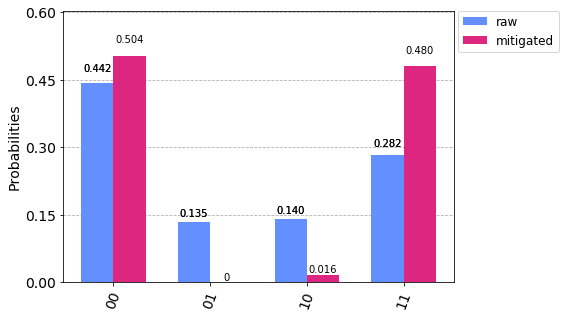

In [27]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter_sub = meas_fitter_sub.filter

# Results with mitigation
mitigated_results = meas_filter_sub.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])